# COVID-19 Prediction

*"" This Script is used to classify the X-ray Images to identify if the patient is corona Postive or Negative ""*

**author** = 'Prasanth Damodharan'

**email** = 'prasanthdamo@gmail.com'



**Import Packages**

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from imutils import paths
import cv2
import seaborn as sns

In [ ]:
imagePaths = list(paths.list_images('/content/drive/My Drive/Xray_500'))

**Fetching images**  

In [ ]:
# grab the list of images from dataset directory, then initialize
# the list of data (i.e., images) and class images

data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

**Label Encoding**

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

**Creating Layers**

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
## Average Pooling: Calculate the average value for each patch on the feature map.
## Maximum Pooling (or Max Pooling): Calculate the maximum value for each patch of the feature map.

headModel = AveragePooling2D(pool_size=(4, 4))(headModel)

## Flattening is converting the data into a 1-dimensional array for inputting it to the next layer.
## We flatten the output of the convolutional layers to create a single long feature vector. 
## And it is connected to the final classification model, which is called a fully-connected layer

headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
## Drop out used in thinning the density of layer and reduce overfitting
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


**Initializing CNN Model**

In [ ]:
# Mentioning the  initial learning rate, number of epochs to train for,and batch size

INIT_LR = 0.001
EPOCHS = 25
BS = 8

In [ ]:
# compile our model
print("[INFO] compiling model...")
## decay used in reducing learning rate so that the model does not saturate with the losses
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy",optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
#Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 

H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
100/100 [==============================] - 10s 105ms/step - loss: 0.6406 - accuracy: 0.6587 - val_loss: 0.5454 - val_accuracy: 0.8050
Epoch 2/25
100/100 [==============================] - 10s 102ms/step - loss: 0.4984 - accuracy: 0.8050 - val_loss: 0.4430 - val_accuracy: 0.8250
Epoch 3/25
100/100 [==============================] - 10s 102ms/step - loss: 0.4315 - accuracy: 0.8438 - val_loss: 0.4061 - val_accuracy: 0.8250
Epoch 4/25
100/100 [==============================] - 10s 103ms/step - loss: 0.3775 - accuracy: 0.8438 - val_loss: 0.3505 - val_accuracy: 0.8800
Epoch 5/25
100/100 [==============================] - 10s 103ms/step - loss: 0.3349 - accuracy: 0.8625 - val_loss: 0.3437 - val_accuracy: 0.8450
Epoch 6/25
100/100 [==============================] - 10s 103ms/step - loss: 0.3136 - accuracy: 0.8737 - val_loss: 0.3051 - val_accuracy: 0.8750
Epoch 7/25
100/100 [==============================] - 10s 104ms/step - loss: 0.2

**Predicting Test Data**

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# Find label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

    negative       0.91      0.96      0.94       100
    positive       0.96      0.91      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[96  4]
 [ 9 91]]
acc: 0.9350
sensitivity: 0.9600
specificity: 0.9100


**Confusion Matrix**

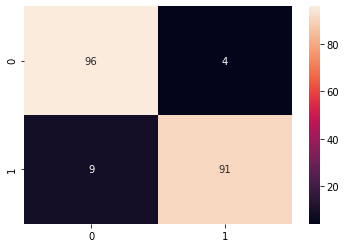

In [ ]:
sns.heatmap(cm, annot=True)

**Plotting Accuracy & Loss**

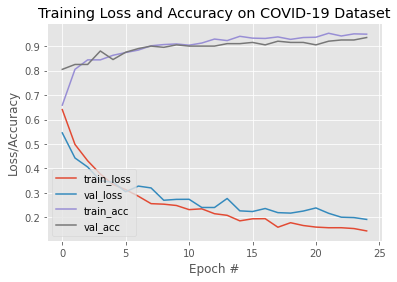

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


**Remarks**:
- On plotting the confusion matrix , the number of False Negative cases were found to be 9. Since this is a medical experiment, the False Negative cases needs to be handled carefully.
- Therefore the user is suggested to run the model thrice and the majority of the three results for a X-ray image should be considered as the result.
